In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random

mpl.rcParams['figure.max_open_warning'] = 10000

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

# TODO
class MLP_XOR(nn.Module):
    def __init__(self, input_size, hidden_size_xor=20, output_size=1):
        super(MLP_XOR, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_xor)
        self.fc2 = nn.Linear(hidden_size_xor, hidden_size_xor)
        self.fc3 = nn.Linear(hidden_size_xor, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [16]:
#initialize

input_size = 1
hidden_size_1 = 2
hidden_size_2 = 2
output_size = 1

# TODO
hidden_size_xor = 20

In [25]:
import scipy.stats
import copy

#helper functions for MPL
def generate_data(func, low=-np.pi, high=np.pi, samples=2000):
    x = torch.linspace(low, high, samples).view(-1, 1)
    y = func(x)
    return x, y

def calc_entropy(matrix):
    EPSILON = 1e-10  # prevent log(0)
    # Flatten the matrix and normalize
    weights = copy.deepcopy(matrix).flatten()
    weights += np.abs(np.min(weights)) + EPSILON  
    weights /= (np.sum(weights) + EPSILON) 

    weights = [max(weight, EPSILON) for weight in weights]
    
    entropy = scipy.stats.entropy(weights)  # Calculate entropy
    return entropy



# TODO
def generate_xor_data(samples=2000):
    # Generate XOR data
    x = torch.randint(2, (samples, 2)).float()
    y = (x.sum(dim=1) == 1).float().view(-1, 1)
    return x, y

def train_model(model, x, y, epochs=10000):
    entropy_over_time = []
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    for epoch in range(epochs):
        model.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        # Calculate and store entropy of the weights
        weights = [param.data.numpy() for param in model.parameters()]
        entropy = np.mean([calc_entropy(weight) for weight in weights])
        entropy_over_time.append(entropy)

        if (epoch % 1000 == 0):
            print('Epoch {}, Loss {:.4f}, Entropy {:.4f}'.format(epoch, loss.item(), entropy))

    # Plot entropy over time
    plt.figure(figsize=(10, 5))
    plt.plot(entropy_over_time, label='Entropy over time')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Entropy')
    plt.title('Entropy of weights over time during training')
    plt.grid(True)
    plt.show()

    return model

# TODO
def train_xor_model(model, x, y, epochs=20000):
    entropy_over_time = []
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    for epoch in range(epochs):
        model.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        # Calculate and store entropy of the weights
        # Calculate and store entropy of the weights
        weights = [param.data.cpu().numpy() for param in model.parameters()]
        entropy = np.mean([calc_entropy(weight) for weight in weights])
        entropy_over_time.append(entropy)

        if (epoch % 1000 == 0):
            print('Epoch {}, Loss {:.4f}, Entropy {:.4f}'.format(epoch, loss.item(), entropy))
            
    # Plot entropy over time
    plt.figure(figsize=(10, 5))
    plt.plot(entropy_over_time, label='Entropy over time')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Entropy')
    plt.title('Entropy of weights over time during training')
    plt.grid(True)
    plt.show()

    return model

def evaluate_model(model, x, y):
    y_pred = model(x)
    mse_loss = nn.MSELoss()(y_pred, y).item()
    r2 = r2_score(y.detach().numpy(), y_pred.detach().numpy())
    print()

    print("MSE Loss: ", mse_loss)
    print("R2 Score: ", r2)

# TODO
def evaluate_xor_model(model, x, y):
    y_pred = model(x)
    y_pred = (y_pred > 0.5).float()  # Apply threshold
    correct = (y_pred == y).float().sum()  # Count correct predictions
    accuracy = correct / x.shape[0]  # Calculate accuracy
    print("Accuracy: ", accuracy.item())

def plot_predictions(func_name, model, x, y):
    y_pred = model(x)
    plt.figure(figsize=(10, 5))
    plt.plot(x.detach().numpy(), y.detach().numpy(), label='True function')
    plt.plot(x.detach().numpy(), y_pred.detach().numpy(), label='MLP predictions')
    plt.legend()
    # plt.savefig(f'{func_name}_fit.png')  # Save the plot to a file
    plt.show()

# TODO
def plot_xor_predictions(func_name, model, x, y):
    y_pred = model(x) > 0.5  # Get binary predictions
    y_pred = y_pred.detach().numpy()
    plt.figure(figsize=(10, 5))
    # Color code: 1s as red, 0s as blue
    colors = ['red' if yt == 1 else 'blue' for yt in y_pred]
    # Scatter plot with color coding
    plt.scatter(x[:, 0], x[:, 1], color=colors)
    plt.title('Predicted XOR Function')
    plt.xlabel('Input 1')
    plt.ylabel('Input 2')
    plt.grid(True)
    #plt.show()

def MLP_get_weights(model):
    weights_dict = {}
    i = 1
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            weight_matrix = layer.weight.data
            weight_matrix = weight_matrix.detach().numpy()
            weights_dict['weights_layer{}'.format(i)] = weight_matrix
            i += 1
    return weights_dict

def plot_graph_and_spectral_density(G, adj_matrix):
    # Visualize the graph
    plt.figure()
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='k')
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title('Graph with {} nodes'.format(G.number_of_nodes()), fontsize=15)
    plt.show()

    # Print the adjecent matrix
    # print(adj_matrix)

    # Perform eigendecomposition on the adjacency matrix
    eigenvalues = np.linalg.eigvalsh(adj_matrix)
    # print(eigenvalues)
    plt.scatter(eigenvalues, [0] * len(eigenvalues))
    plt.show()

    # Create a new figure for the spectral density
    plt.figure()  # Create a new figure
    print('Spectral Density')
    # Calculate the spectral density
    density, bins, _ = plt.hist(eigenvalues, bins='auto', density=True)
    plt.show()  # Show the spectral density plot

def MLP_to_non_supra_adjacency_matrix(adj_matrix):
    # get the dimensions of the adjacency matrix
    dim = adj_matrix.shape[0]

    # generate a list with the original node order
    original_order = list(range(dim))

    # create a new order by shuffling the original order
    new_order = original_order.copy()
    random.shuffle(new_order)

    # create a new adjacency matrix with the new order
    shuffled_adj_matrix = adj_matrix[:, new_order][new_order]

    # Create graph from shuffled adjacency matrix
    G = nx.from_numpy_array(shuffled_adj_matrix, create_using=nx.DiGraph)

    # Add weights to the edges
    for i, j in G.edges():
        G[i][j]['weight'] = shuffled_adj_matrix[i, j]

    print('Undirected Non-Supra Adjacency Matrix')
    plot_graph_and_spectral_density(G, shuffled_adj_matrix)


def MLP_to_supra_adjacency_matrix(model):

    weights = MLP_get_weights(model)
    # Original Weights
    # weights_layer1 = weights['weights_layer1']
    # weights_layer2 = weights['weights_layer2']
    # weights_layer3 = weights['weights_layer3']

    # Convert the weights from floating numbers to strings to beautify the matrices and graphs
    weights_layer1 = np.round(weights['weights_layer1'], 2).astype(str)
    weights_layer2 = np.round(weights['weights_layer2'], 2).astype(str)
    weights_layer3 = np.round(weights['weights_layer3'], 2).astype(str)

    # print(weights_layer1)
    # print(weights_layer2)
    # print(weights_layer3)

    # Create a directed graph
    G = nx.DiGraph()

    # Add input node to the graph
    G.add_node(0)

    # Iterate through the weights and add each node and edge to the graph
    for i, weight in enumerate(weights_layer1, start=1):
        G.add_node(i)
        G.add_edge(0, i, weight=float(weight))

    # Get the number of nodes in the graph so far
    num_nodes = G.number_of_nodes()
    # Iterate through the weights of the second layer and add each node and edge to the graph
    for i, row_weights in enumerate(weights_layer2, start=1):
        for j, weight in enumerate(row_weights, start=num_nodes):
            if not G.has_node(j):
                G.add_node(j)
            G.add_edge(i, j, weight=float(weight))

    # Get the number of nodes in the graph so far
    num_nodes = G.number_of_nodes()

    # Add the last node for the third layer
    G.add_node(num_nodes)

    # Iterate through the weights of the third layer and add each edge to the graph
    for i, weight in enumerate(weights_layer3[0], start=num_nodes - weights_layer3.shape[1]):
        G.add_edge(i, num_nodes, weight=float(weight))

    # Convert the graph to undirected
    G = G.to_undirected()
    # Convert the graph to an adjacency matrix
    adj_matrix = nx.to_numpy_array(G)

    print('Undirected Supra Adjacency Matrix')
    plot_graph_and_spectral_density(G, adj_matrix)

    # Print the non-supra Adjacency matrix
    MLP_to_non_supra_adjacency_matrix(adj_matrix)

def MLP_matrix_representation(model):
    matrix_representation = []
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            weight_matrix = layer.weight.data
            # Converting the tensor to numpy array
            weight_matrix = weight_matrix.detach().numpy()
            matrix_representation.append(weight_matrix)
    return matrix_representation

def print_and_save_heatmap(matrices, suffix):
    for i, matrix in enumerate(matrices):
        print(f"Matrix for layer {i+1}:")
        print()  # Add a line break for readability

        plt.figure(figsize=(8, 8))
        sns.heatmap(matrix, cmap='coolwarm', center=0)
        plt.title(f'{suffix}_Adjacency Matrix for Layer {i+1}')
        plt.savefig(f'{suffix}_layer_{i+1}_adjacency_matrix.png')  # Save the plot to a file
        plt.show()  # Change this line

def run_experiment(func_name, func, model_class=MLP, epochs=10000, low=-np.pi, high=np.pi):
    x, y = generate_data(func, low, high)
    pre_train_model = model_class()

    # Print and plot adjacency matrices before training
    print('Before Training:')
    MLP_to_supra_adjacency_matrix(pre_train_model)

    # Print and plot_matrices
    # adjacency_matrix_before = MLP_matrix_representation(pre_train_model)
    # print_and_save_heatmap(adjacency_matrix_before, f'{func_name}_before')

    # Train the model
    trained_model = train_model(pre_train_model, x, y, epochs)

    # Print and plot adjacency matrices after training
    print('After Training:')
    MLP_to_supra_adjacency_matrix(trained_model)

    # Print and plot_matrices
    # adjacency_matrix_after = MLP_matrix_representation(trained_model)
    # print_and_save_heatmap(adjacency_matrix_after, f'{func_name}_after')

    # Evaluate the model and plot the predictions
    evaluate_model(trained_model, x, y)
    plot_predictions(func_name, trained_model, x, y)

    # Return the models before and after training
    return pre_train_model, trained_model

# TODO
def run_experiment_xor(func_name, model_class=MLP_XOR, epochs=20000):
    x, y = generate_xor_data()
    model = model_class(input_size=2)

    # Print and plot adjacency matrices before training
    print('Before Training:')
    matrix = MLP_to_supra_adjacency_matrix(model)
    print_and_save_heatmap(matrix, f'{func_name}_before')

    # Train the model
    model = train_model(model, x, y, epochs)

    # Print and plot adjacency matrices after training
    print('After Training:')
    matrix = MLP_to_supra_adjacency_matrix(model)
    print_and_save_heatmap(matrix, f'{func_name}_after')

    # Evaluate the model and plot the predictions
    evaluate_xor_model(model, x, y)
    plot_xor_predictions(func_name, model, x, y)

# Call the function and get both models
# pre_train_sin_model, trained_sin_model = run_experiment("Sin", torch.sin)

# # Save the models
# torch.save(pre_train_sin_model.state_dict(), 'pre_train_sin_model.pth')
# torch.save(trained_sin_model.state_dict(), 'trained_sin_model.pth')


--- Sin Function ---
Before Training:
Undirected Supra Adjacency Matrix


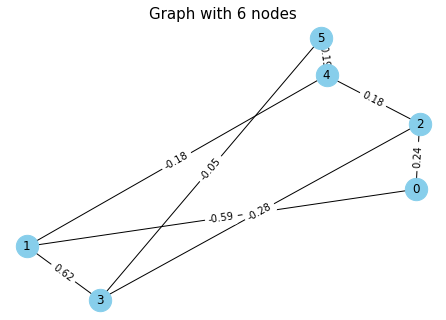

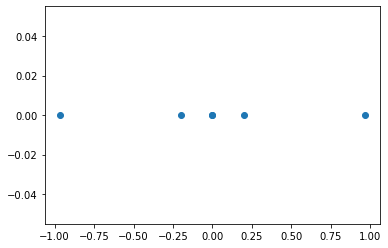

Spectral Density


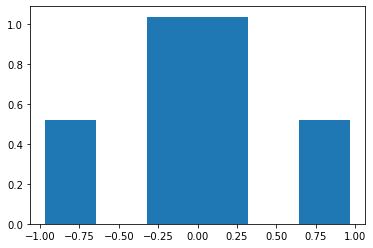

Undirected Non-Supra Adjacency Matrix


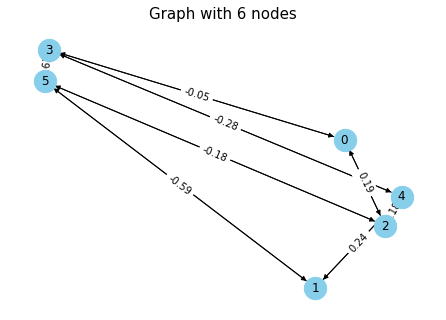

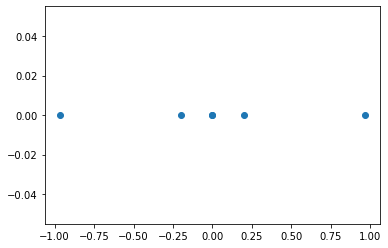

Spectral Density


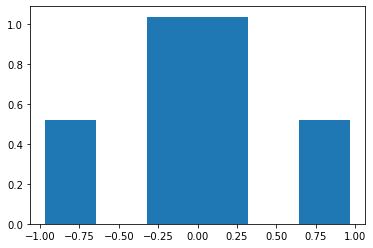

Epoch 0, Loss 0.4274, Entropy 2.5649
Epoch 1000, Loss 0.1181, Entropy 2.4583
Epoch 2000, Loss 0.1032, Entropy 2.3517
Epoch 3000, Loss 0.0839, Entropy 2.5649
Epoch 4000, Loss 0.0629, Entropy 2.5649
Epoch 5000, Loss 0.0480, Entropy 2.5649
Epoch 6000, Loss 0.0399, Entropy 2.3517
Epoch 7000, Loss 0.0355, Entropy 2.5649
Epoch 8000, Loss 0.0326, Entropy 2.3517
Epoch 9000, Loss 0.0298, Entropy 2.4583


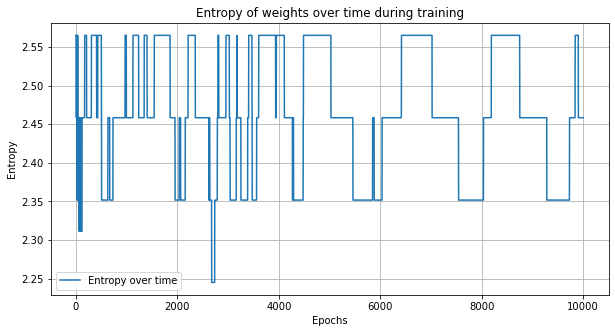

After Training:
Undirected Supra Adjacency Matrix


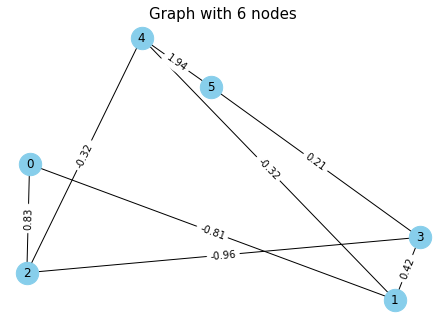

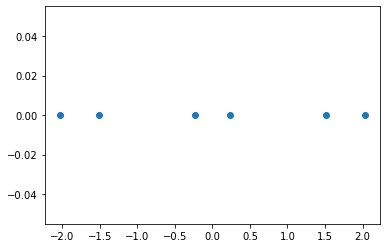

Spectral Density


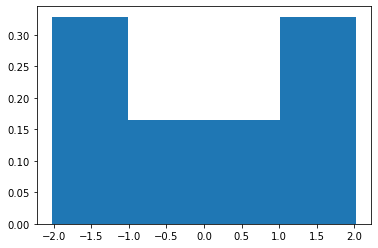

Undirected Non-Supra Adjacency Matrix


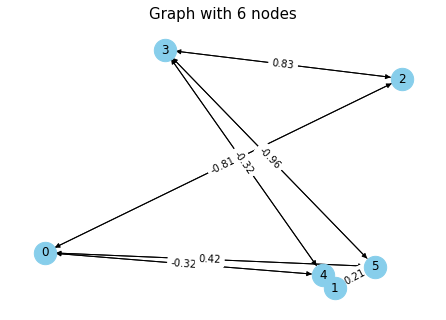

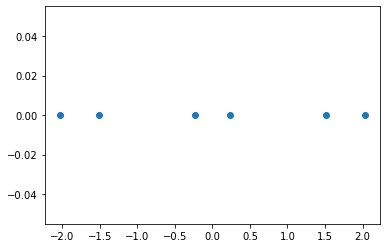

Spectral Density


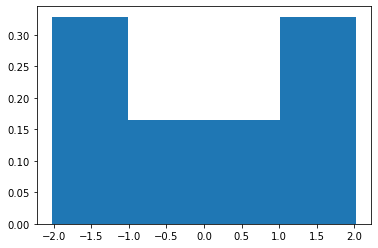


MSE Loss:  0.026736201718449593
R2 Score:  0.9465008471908654


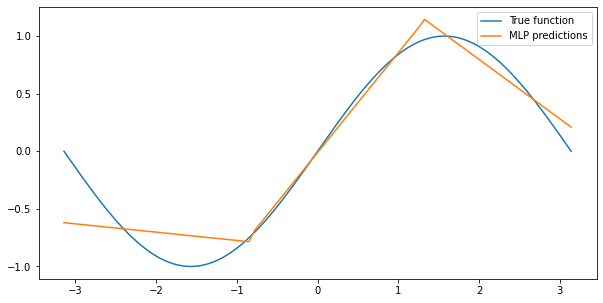


--- Cos Function ---
Before Training:
Undirected Supra Adjacency Matrix


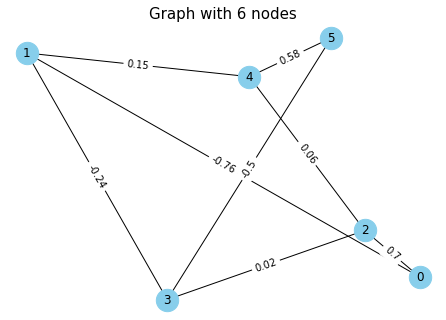

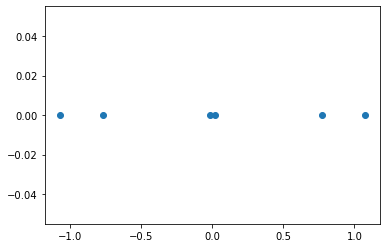

Spectral Density


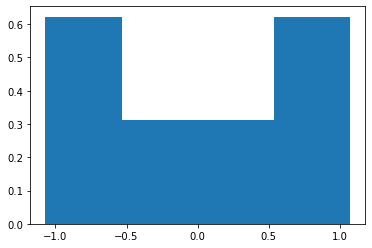

Undirected Non-Supra Adjacency Matrix


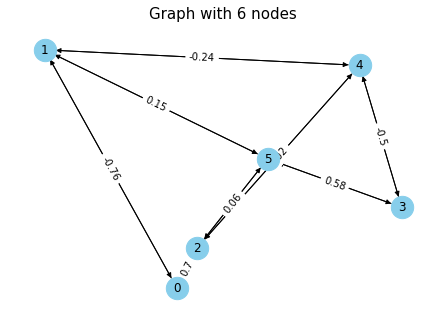

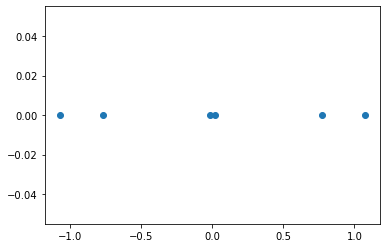

Spectral Density


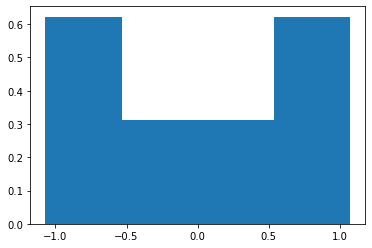

Epoch 0, Loss 1.0799, Entropy 2.3517
Epoch 1000, Loss 0.0195, Entropy 2.2048
Epoch 2000, Loss 0.0042, Entropy 2.3517
Epoch 3000, Loss 0.0033, Entropy 2.3517
Epoch 4000, Loss 0.0031, Entropy 2.3517
Epoch 5000, Loss 0.0030, Entropy 2.4583
Epoch 6000, Loss 0.0030, Entropy 2.4583
Epoch 7000, Loss 0.0030, Entropy 2.4583
Epoch 8000, Loss 0.0030, Entropy 2.4583
Epoch 9000, Loss 0.0030, Entropy 2.3517


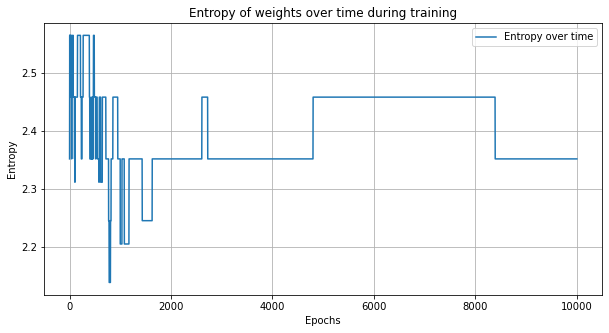

After Training:
Undirected Supra Adjacency Matrix


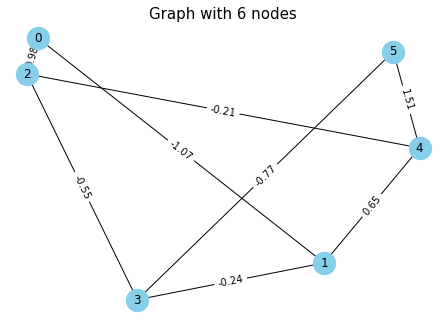

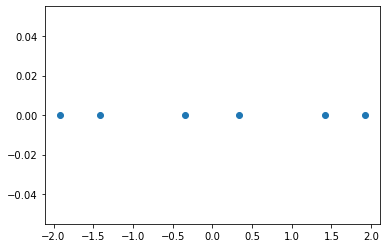

Spectral Density


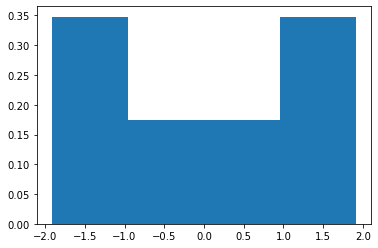

Undirected Non-Supra Adjacency Matrix


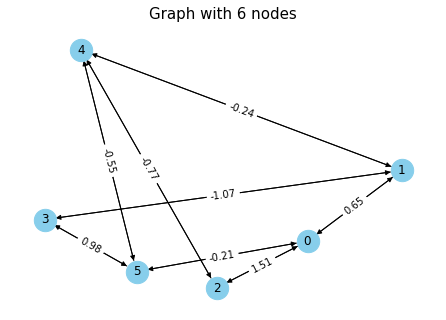

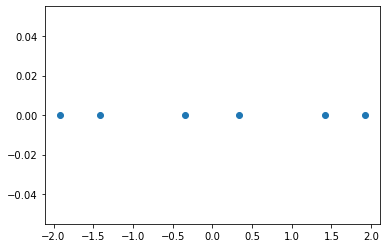

Spectral Density


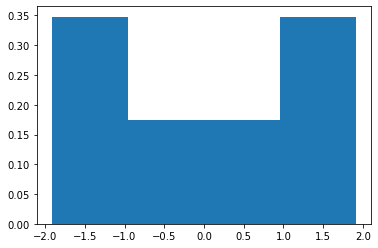


MSE Loss:  0.003002720419317484
R2 Score:  0.9939975577315847


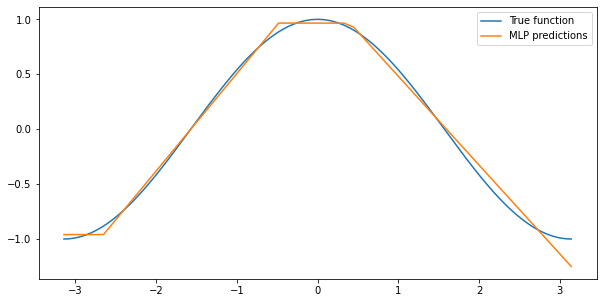


--- Exp Function ---
Before Training:
Undirected Supra Adjacency Matrix


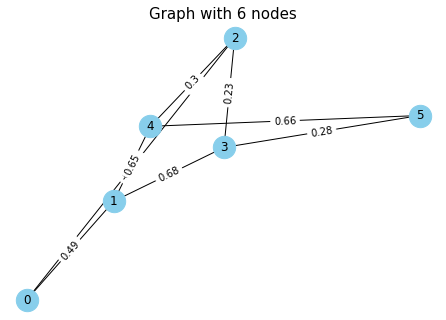

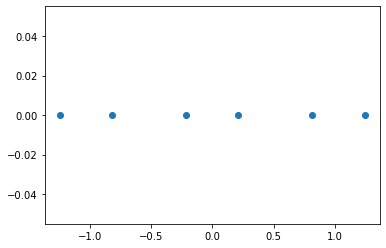

Spectral Density


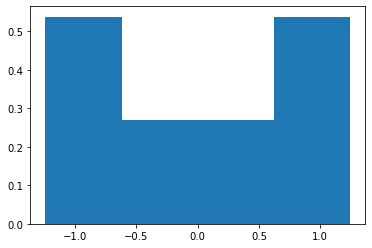

Undirected Non-Supra Adjacency Matrix


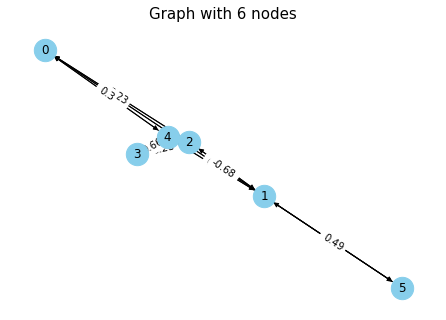

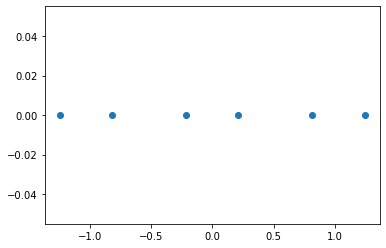

Spectral Density


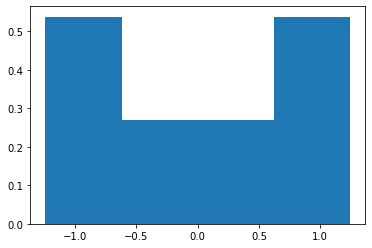

Epoch 0, Loss 1.5383, Entropy 2.2048
Epoch 1000, Loss 0.0127, Entropy 2.4583
Epoch 2000, Loss 0.0097, Entropy 2.3517
Epoch 3000, Loss 0.0095, Entropy 2.5649
Epoch 4000, Loss 0.0095, Entropy 2.5649
Epoch 5000, Loss 0.0095, Entropy 2.5649
Epoch 6000, Loss 0.0095, Entropy 2.5649
Epoch 7000, Loss 0.0095, Entropy 2.5649
Epoch 8000, Loss 0.0095, Entropy 2.5649
Epoch 9000, Loss 0.0095, Entropy 2.5649


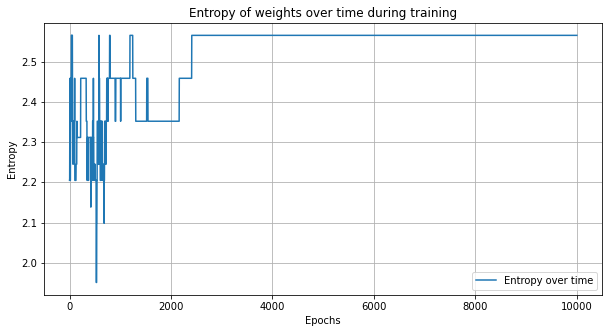

After Training:
Undirected Supra Adjacency Matrix


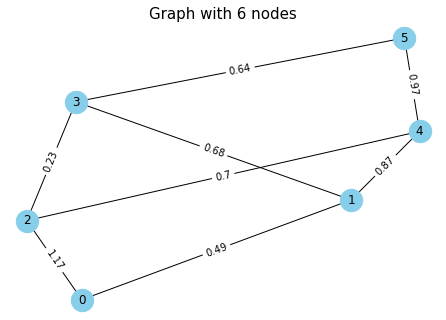

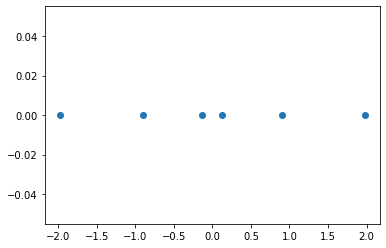

Spectral Density


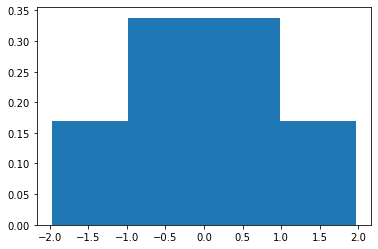

Undirected Non-Supra Adjacency Matrix


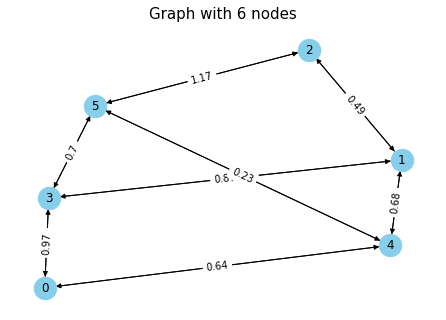

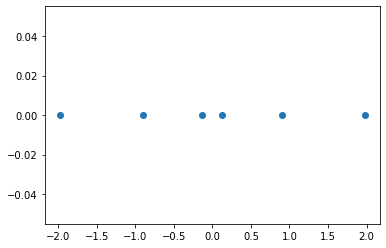

Spectral Density


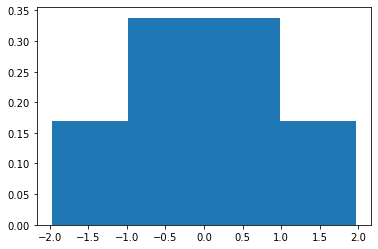


MSE Loss:  0.009511420503258705
R2 Score:  0.9780273162671664


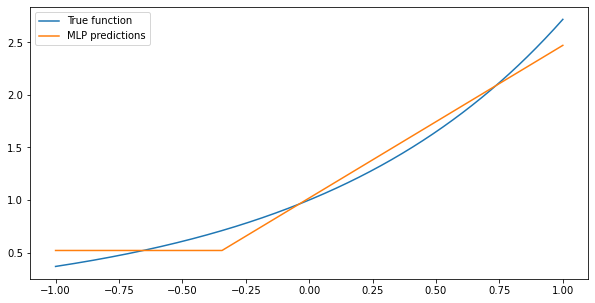


--- Polynomial Function ---
Before Training:
Undirected Supra Adjacency Matrix


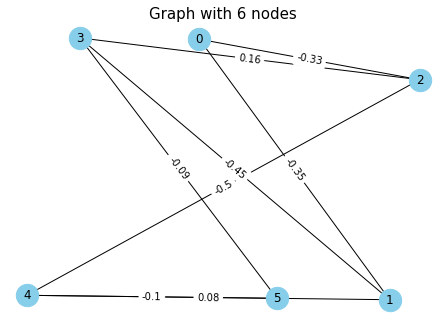

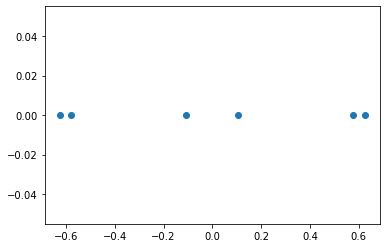

Spectral Density


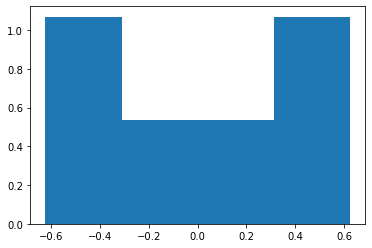

Undirected Non-Supra Adjacency Matrix


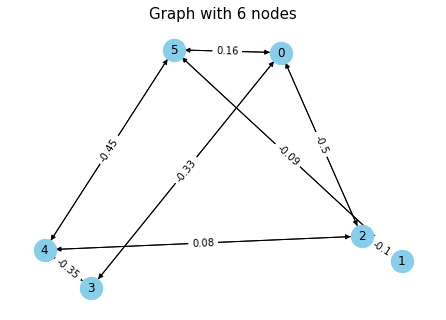

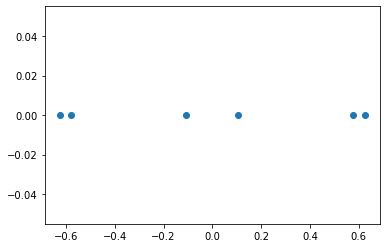

Spectral Density


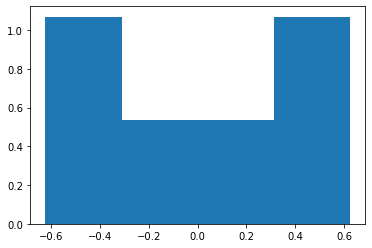

Epoch 0, Loss 0.0903, Entropy 2.3517
Epoch 1000, Loss 0.0352, Entropy 2.3517
Epoch 2000, Loss 0.0342, Entropy 2.5649
Epoch 3000, Loss 0.0316, Entropy 2.3114
Epoch 4000, Loss 0.0243, Entropy 2.4583
Epoch 5000, Loss 0.0146, Entropy 2.4583
Epoch 6000, Loss 0.0086, Entropy 2.4583
Epoch 7000, Loss 0.0053, Entropy 2.3114
Epoch 8000, Loss 0.0033, Entropy 2.2048
Epoch 9000, Loss 0.0021, Entropy 2.3114


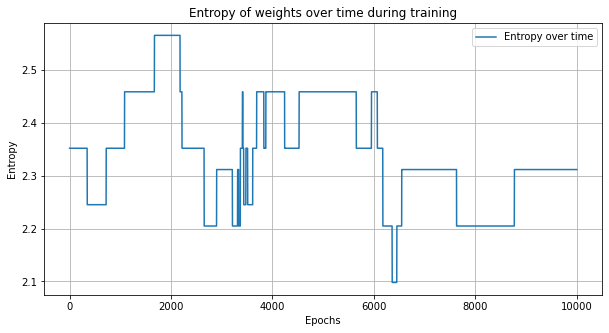

After Training:
Undirected Supra Adjacency Matrix


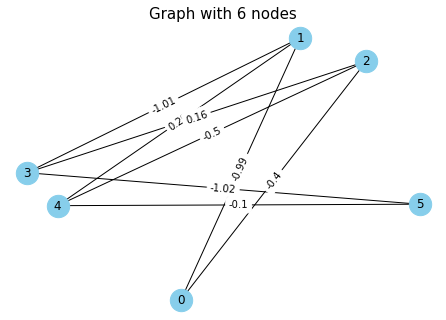

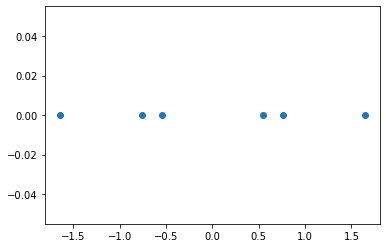

Spectral Density


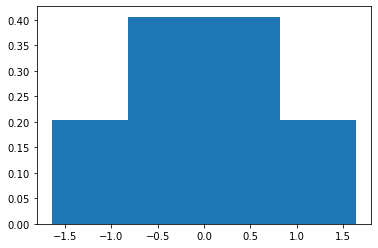

Undirected Non-Supra Adjacency Matrix


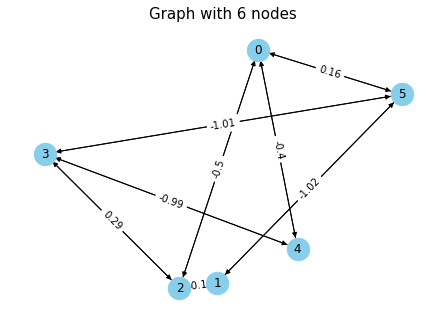

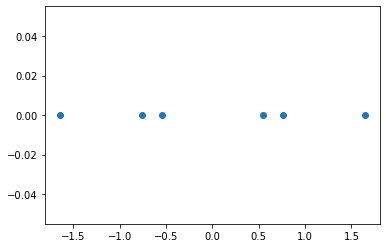

Spectral Density


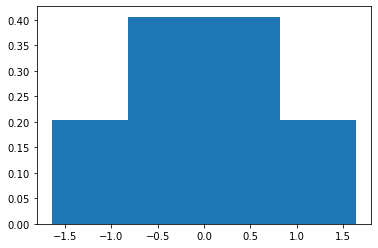


MSE Loss:  0.0015101662138476968
R2 Score:  0.9570517459233521


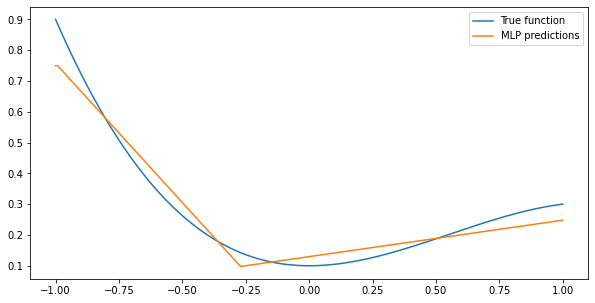


--- Square Root Function ---
Before Training:
Undirected Supra Adjacency Matrix


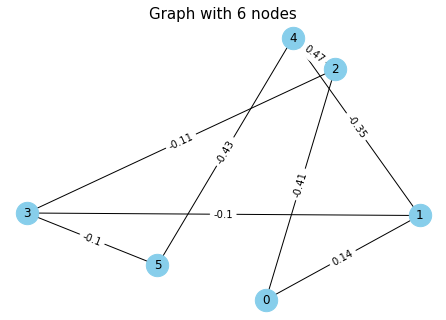

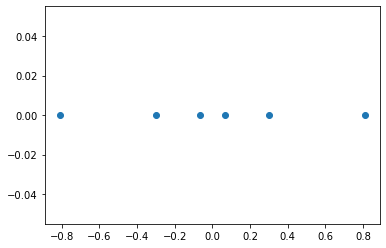

Spectral Density


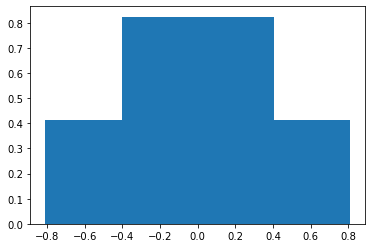

Undirected Non-Supra Adjacency Matrix


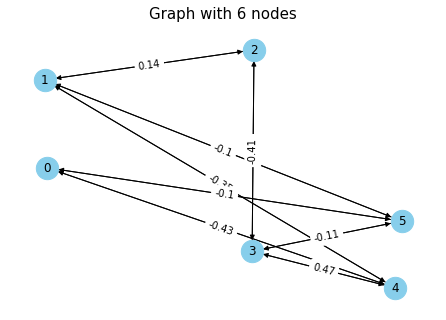

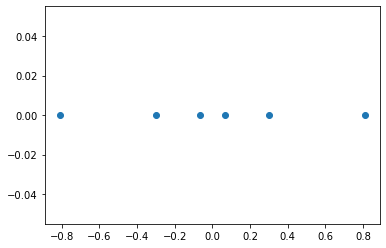

Spectral Density


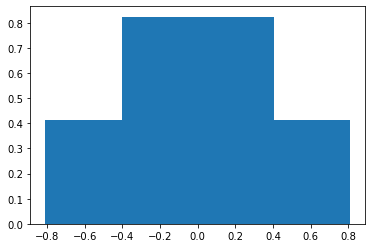

Epoch 0, Loss 0.0740, Entropy 2.3517
Epoch 1000, Loss 0.0525, Entropy 2.3517
Epoch 2000, Loss 0.0515, Entropy 2.3517
Epoch 3000, Loss 0.0482, Entropy 2.3114
Epoch 4000, Loss 0.0374, Entropy 2.4583
Epoch 5000, Loss 0.0079, Entropy 2.3517
Epoch 6000, Loss 0.0015, Entropy 2.4583
Epoch 7000, Loss 0.0013, Entropy 2.4583
Epoch 8000, Loss 0.0013, Entropy 2.4583
Epoch 9000, Loss 0.0013, Entropy 2.4583


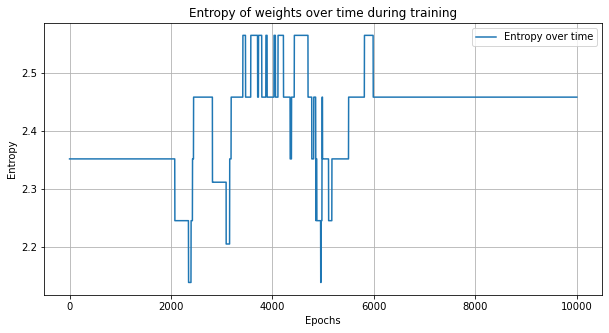

After Training:
Undirected Supra Adjacency Matrix


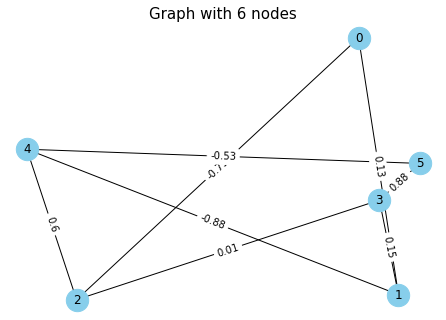

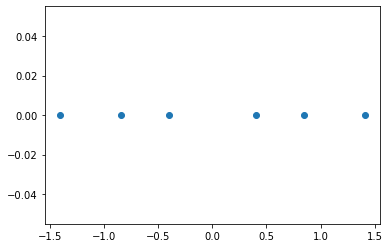

Spectral Density


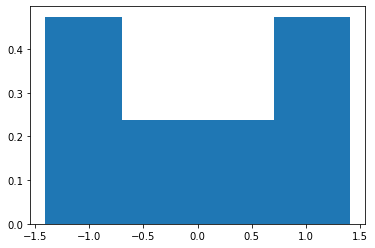

Undirected Non-Supra Adjacency Matrix


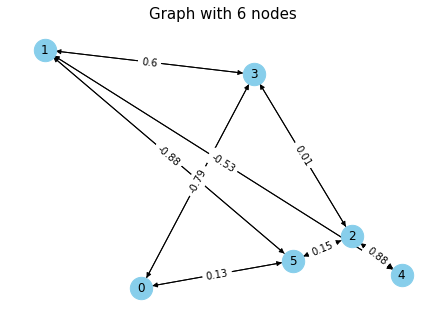

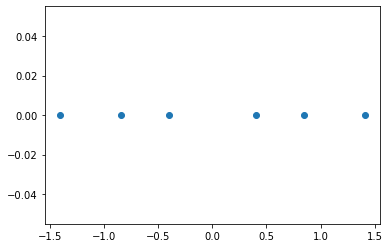

Spectral Density


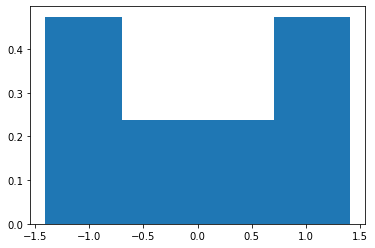

In [26]:
# Test the function with different functions
print("\n--- Sin Function ---")
run_experiment("Sin", torch.sin)

print("\n--- Cos Function ---")
run_experiment("Cos", torch.cos)

print("\n--- Exp Function ---")
run_experiment("Exp", torch.exp, low=-1, high=1)

print("\n--- Polynomial Function ---")
run_experiment("Polynomial", lambda x: 0.5*x**2 - 0.3*x**3 + 0.1, low=-1, high=1)

print("\n--- Square Root Function ---")
run_experiment("Square_Root", torch.sqrt, low=0.01, high=1)

print("\n--- Gaussian Function ---")
run_experiment("Gaussian", lambda x: torch.exp(-x**2), low=-2, high=2)